# install lib



In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git
!pip install transformers
!pip install bitsandbytes
!pip install datasets

In [11]:
import numpy as np
import random

import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm.auto import tqdm

from datasets import load_dataset

from transformers import AutoProcessor, AutoModelForCausalLM, BitsAndBytesConfig

from peft import LoraConfig, get_peft_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# data prepration

https://huggingface.co/datasets/Norod78/cartoon-blip-captions

In [3]:
dataset = load_dataset("Norod78/cartoon-blip-captions")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3141 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 3141
    })
})

In [4]:
# train test split
train_val_split = dataset['train'].train_test_split(test_size=0.2)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [5]:
len(train_dataset), len(val_dataset)

(2512, 629)

In [6]:
# plot sample
train_dataset[0]["text"]

'a man in a classroom with a black t - shirt and black shorts'

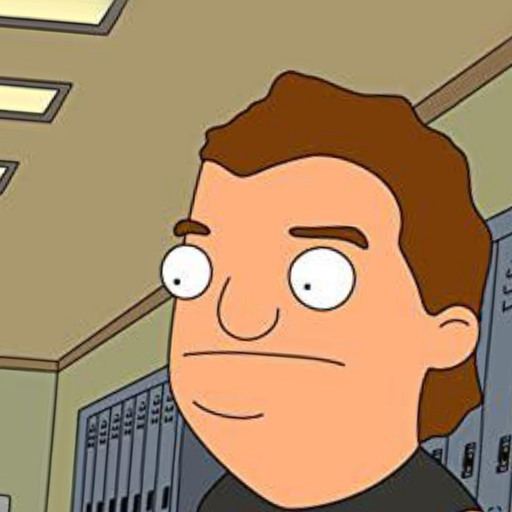

In [7]:
train_dataset[0]["image"]

# load model

In [8]:
# let quatize the model in 4 bit so we can train it on T4
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

read more about GiT

https://arxiv.org/pdf/2205.14100

also, we can use blip2

In [9]:
# mapping device to cuda and download model
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/git-base",
    device_map=device,
    quantization_config=quantization_config
)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

read more about LoRA


*   https://huggingface.co/docs/peft/en/package_reference/lora
*   https://medium.com/@manyi.yim/more-about-loraconfig-from-peft-581cf54643db
*   https://github.com/huggingface/peft



In [12]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["fc1", "fc2", "query", "key", "value", "dense", "q_proj", "k_proj", "v_proj", "out_proj"],
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 3,981,312 || all params: 180,600,378 || trainable%: 2.2045


# data loader

In [13]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"],
            padding="max_length",
            return_tensors="pt"
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}

        encoding["text"] = item["text"]

        return encoding

In [14]:
# processing caption
def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [15]:
train_dataset = ImageCaptioningDataset(train_dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)

val_dataset = ImageCaptioningDataset(val_dataset, processor)
validation_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)

# training

In [16]:
num_epochs = 5
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    weight_decay=0.01
)
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=len(train_dataloader) * num_epochs
)

In [17]:
# training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    total_train_loss = 0.0
    total_batches = 0

    # set train mode
    model.train()

    for idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

        # mapping device
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["input_ids"].to(device)

        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            labels=labels,
            attention_mask=attention_mask
        )

        loss = outputs.loss
        if loss.ndim > 0:
            loss = loss.mean()

        total_train_loss += loss.item()
        total_batches += 1

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # display train loss of each batch
        tqdm.write(f"\rTrain Loss: {loss.item():.6f}", end='')

    average_train_loss = total_train_loss / total_batches
    print(f"\nTrain Loss for Epoch {epoch + 1}: {average_train_loss:.4f}")

    # set eval mode
    model.eval()

    total_val_loss = 0.0
    total_val_batches = 0

    with torch.no_grad():
        for idx, batch in tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
            # mapping device
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["input_ids"].to(device)

            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                labels=labels,
                attention_mask=attention_mask
            )

            loss = outputs.loss
            if loss.ndim > 0:
                loss = loss.mean()

            total_val_loss += loss.item()
            total_val_batches += 1
            labels_decoded = processor.batch_decode(labels, skip_special_tokens=True)

            # display validation loss of each batch
            tqdm.write(f"\rValidation Loss: {loss.item():.6f}", end='')

    average_val_loss = total_val_loss / total_val_batches
    print(f"\nValidation Loss for Epoch {epoch + 1}: {average_val_loss:.4f}")


Epoch: 1


  0%|          | 0/628 [00:00<?, ?it/s]

Train Loss: 4.074219
Train Loss for Epoch 1: 5.4426


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 6.804688
Validation Loss for Epoch 1: 4.7501
Epoch: 2


  0%|          | 0/628 [00:00<?, ?it/s]

Train Loss: 4.632812
Train Loss for Epoch 2: 4.7681


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 2.353516
Validation Loss for Epoch 2: 4.5821
Epoch: 3


  0%|          | 0/628 [00:00<?, ?it/s]

Train Loss: 4.972656
Train Loss for Epoch 3: 4.5871


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 2.085938
Validation Loss for Epoch 3: 4.4962
Epoch: 4


  0%|          | 0/628 [00:00<?, ?it/s]

Train Loss: 3.812500
Train Loss for Epoch 4: 4.5233


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 1.597656
Validation Loss for Epoch 4: 4.4292
Epoch: 5


  0%|          | 0/628 [00:00<?, ?it/s]

Train Loss: 2.322266
Train Loss for Epoch 5: 4.4034


  0%|          | 0/158 [00:00<?, ?it/s]

Validation Loss: 2.515625
Validation Loss for Epoch 5: 4.3761


more about metric

Most image caption use BLEU score for evaluate the model output.

https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

# save model to huggingface

In [18]:
from huggingface_hub import notebook_login

notebook_login()

In [27]:
model.push_to_hub("Madnesss/aibxesck-img-cap-git")
processor.push_to_hub("Madnesss/aibxesck-img-cap-git")

model.safetensors:   0%|          | 0.00/190M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Madnesss/aibxesck-img-cap-git/commit/25cff53a21051753f7697816168bc2dfbd4dff71', commit_message='Upload processor', commit_description='', oid='25cff53a21051753f7697816168bc2dfbd4dff71', pr_url=None, pr_revision=None, pr_num=None)

# inference test

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("Madnesss/img_cap_aibxesck")
model = AutoModelForCausalLM.from_pretrained(
    "Madnesss/aibxesck-img-cap-git",
    device_map=device,
    quantization_config=quantization_config
)

config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/190M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [33]:
inputs = processor(images=dataset['train'][100]["image"], return_tensors="pt").to("cuda") # replace "dataset['train'][102]["image"]" with your image path

pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=128)
processor.batch_decode(generated_ids, skip_special_tokens=True)

['illustration of a woman looking at a man']

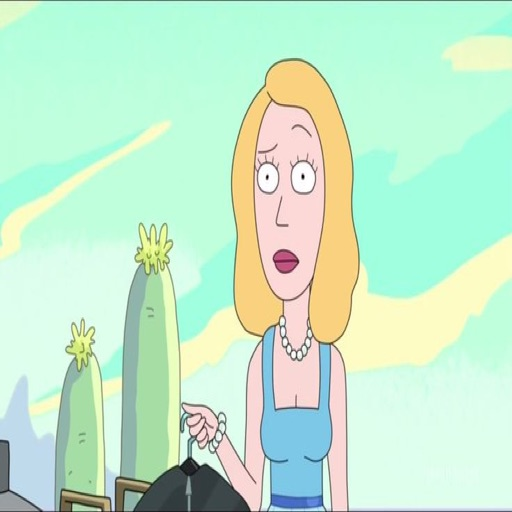

In [34]:
dataset['train'][100]["image"]